<a href="https://colab.research.google.com/github/tgsrkg/ML_RGR/blob/main/%D0%90%D0%92%D0%A0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Метрики для оценки качества модели**



1.   **Средняя абсолютная ошибка (MAE)**

 $$MAE=\frac{1}{n}\sum\limits_{i=1}^{n}|\hat{y_i}-y_i|$$
2.   **Средняя квадратичная ошибка (MSE)**
$$MSE=\frac{1}{n}\sum\limits_{i=1}^{n}(\hat{y_i}-y_i)^2$$
3.  **Средняя абсолютная процентная ошибка (MAPE)**
$$MAPE=\frac{1}{n}\sum\limits_{i=1}^{n}\biggl|\frac{\hat{y_i}-y_i}{y_i}\biggr|\cdot 100 \%$$
4. **R-квадрат ($R^2$)**
$$R^2 = 1 - \frac{\sum\limits_{i=1}^n (\hat{y_i}-y_i)^2}{\sum\limits_{i=1}^n (\bar{y_i}-y_i)^2}$$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


import warnings
warnings.filterwarnings("ignore")

In [ ]:
oil_data = pd.read_csv('oil.csv').rename({'dcoilwtico': 'price'}, axis=1).bfill()

In [ ]:
# Преобразуем столбец 'date' в формат datetime
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1218 non-null   datetime64[ns]
 1   price   1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


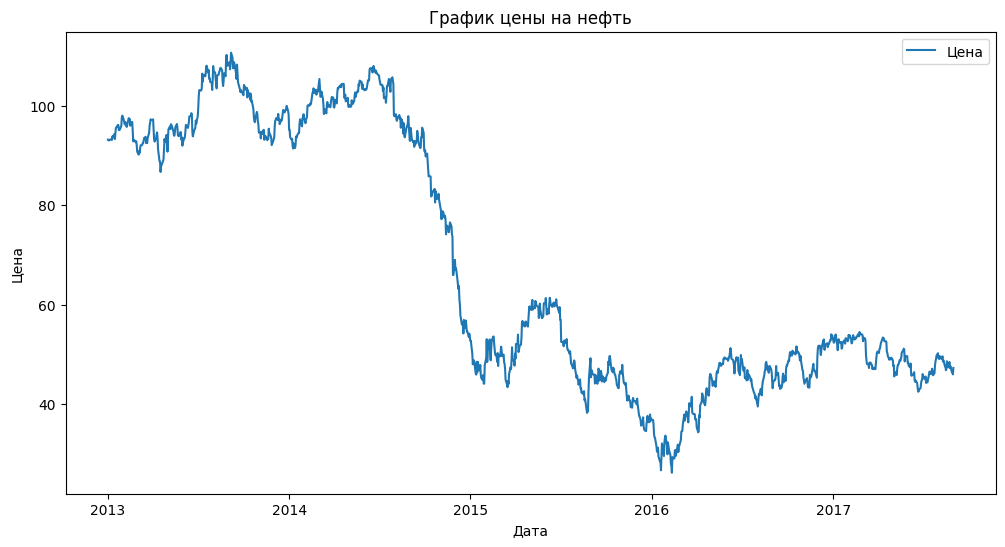

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(oil_data['date'], oil_data['price'], label='Цена')

# Устанавливаем заголовки и легенду
plt.title('График цены на нефть')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

In [ ]:
oil_data.head(10)

In [ ]:
# добавим новые признаки - временные отсчеты и лаг1
oil_data['time'] = np.arange(len(oil_data.index))
oil_data['lag_1'] = oil_data['price'].shift(1)
oil_data.dropna(inplace=True)

In [ ]:
oil_data = oil_data.set_index('date')

In [ ]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1217 entries, 2013-01-02 to 2017-08-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1217 non-null   float64
 1   time    1217 non-null   int64  
 2   lag_1   1217 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 38.0 KB


# **Базовая модель (base model)**

Для временных рядов с трендом хорошей базовой линией (моделью) является **наивный прогноз**.

Наивное прогнозирование означает, что мы всегда прогнозируем будущее значение как последнее доступное значение.

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))
plot_acf(oil_data['price'], ax=ax1, lags=50);

In [ ]:
oil_data.rename({'lag_1': 'naive_forecast'}, axis = 1, inplace=True)

In [ ]:
oil_data.columns

In [ ]:
df_metrics = pd.DataFrame(index=['MAE', 'MSE', 'MAPE', 'R^2'])

mae = mean_absolute_error(
    oil_data['price'],
    oil_data['naive_forecast']
)
mse = mean_squared_error(
    oil_data['price'],
    oil_data['naive_forecast']
)
mape = mean_absolute_percentage_error(
    oil_data['price'],
    oil_data['naive_forecast']
)
r2 = r2_score(
    oil_data['price'],
    oil_data['naive_forecast']
)

df_metrics['naive_forecast'] = [mae, mse, mape, r2]
df_metrics

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(oil_data['time'], oil_data['price'], label='исходный ряд')
plt.plot(oil_data['time'], oil_data['naive_forecast'], label='наивный прогноз')

# Устанавливаем заголовки и легенду
plt.title('График цены на нефть и наивное прогнозирование')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

**Прогноз ...**

In [ ]:
forecast_ratio = 0.05
forecast_size = int(len(oil_data) * forecast_ratio)

oil_train = oil_data[:-forecast_size]
oil_forecast = oil_data[-forecast_size:]

print(
    f'Мощность исходных данных: {len(oil_data)}\n',
    f'Мощность обучающей выборки: {len(oil_train)}\n',
    f'Мощность тестовой выборки: {len(oil_forecast)}'
)

In [ ]:
value = oil_forecast['price'].iloc[0]
print(value)

oil_forecast['naive_forecast'] = oil_forecast['naive_forecast'].apply(lambda x: value)

In [ ]:
oil_forecast

In [ ]:
mape_naive_forecast = mean_absolute_percentage_error(
    oil_forecast['price'],
    oil_forecast['naive_forecast']
)
r2_naive_forecast = r2_score(
    oil_forecast['price'],
    oil_forecast['naive_forecast']
)

print(f'MAPE наивного прогнозирования: {mape_naive_forecast}')
print(f'R^2 наивного прогнозирования: {r2_naive_forecast}')

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(oil_data['time'], oil_data['price'], label='исходный ряд')
plt.plot(oil_forecast['time'], oil_forecast['naive_forecast'], label='наивный прогноз')

# Устанавливаем заголовки и легенду
plt.title('График цены на нефть и трендовая компонента')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

# Моделирование трендовой компоненты

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(oil_data['time'], oil_data['price'], label='Цена')

# Добавление линии регрессии с помощью Seaborn
sns.regplot(x='time',
            y='price',
            data=oil_data,
            ci=None,
            scatter_kws=dict(color='black'),
            line_kws=dict(color='orange'),
            order=4,
            ax=ax)

ax.set_title('График цены на нефти по временным шагам')
ax.set_xlabel('Время')
ax.set_ylabel('Цена')
ax.legend()
plt.show()

In [ ]:
n = 4

for i in range(1, n + 1):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=i)),
        ('linear', LinearRegression(fit_intercept=False))
    ])
    model = model.fit(oil_data[['time']], oil_data['price'])

    mae = mean_absolute_error(
        oil_data['price'],
        model.predict(oil_data[['time']]),
    )
    mse = mean_squared_error(
        oil_data['price'],
        model.predict(oil_data[['time']]),
    )
    mape = mean_absolute_percentage_error(
        oil_data['price'],
        model.predict(oil_data[['time']]),
    )
    r2 = r2_score(
        oil_data['price'],
        model.predict(oil_data[['time']]),
    )

    oil_data[str(i) + 'regres'] = model.predict(oil_data[['time']])

    df_metrics[str(i) + 'regres'] = [mae, mse, mape, r2]
df_metrics

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(oil_data['time'], oil_data['price'], label='исходный ряд')
for i in range(1, (n + 1)):
    plt.plot(oil_data['time'], oil_data[str(i) + 'regres'], label=(str(i) + 'regres'))

# Устанавливаем заголовки и легенду
plt.title('График цены на нефть и трендовая компонента')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

# **Обучающая и тестовая выборки**

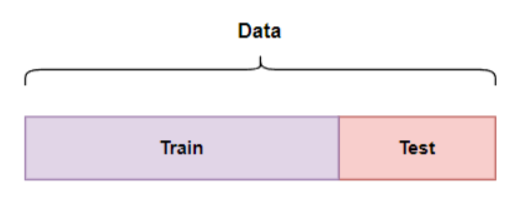

**Разделение данных временных рядов**

Случайное разбиение не будет адекватным, поскольку порядок данных имеет значение.

Вместо этого нужно сделать разбиение таким образом, чтобы все наблюдения в тестовом наборе происходили после наблюдений в обучающем наборе.

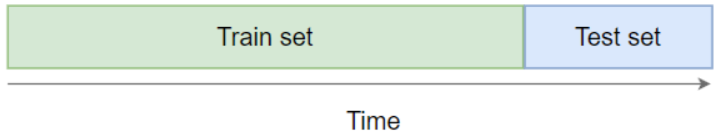

In [ ]:
test_ratio = 0.2
test_size = int(len(oil_data) * test_ratio)

df_train = oil_data[:-test_size]
df_test = oil_data[-test_size:]

print(
    f'Мощность исходных данных: {len(oil_data)}\n',
    f'Мощность обучающей выборки: {len(df_train)}\n',
    f'Мощность тестовой выборки: {len(df_test)}'
)

**Задание:**

1.  модель полинома первой и четвертой степени обучить на обучающей выборке
2.  для моделей вычислить значение метрик $MAPE$ и $R^2$ на обучающей выборке и на тестовой выборке
3.  занести метрики в датафрейм, добавить соответствующие метрики и для базовой модели
4.  отрисовать графики полученных модельных и прогнозных значений

In [ ]:
df_metrics_new = pd.DataFrame(index=['MAPE_train', 'MAPE_test', 'R^2_train', 'R^2_test'])

for i in range(1, 5, 3):
    # ваш код
    ...


**Кросс-валидация для временных рядов**

**Схема 1**

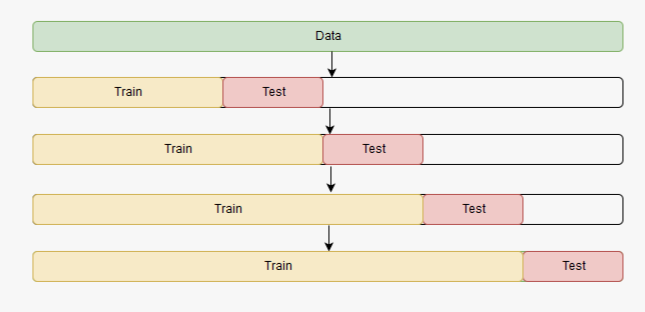


**Схема 2**

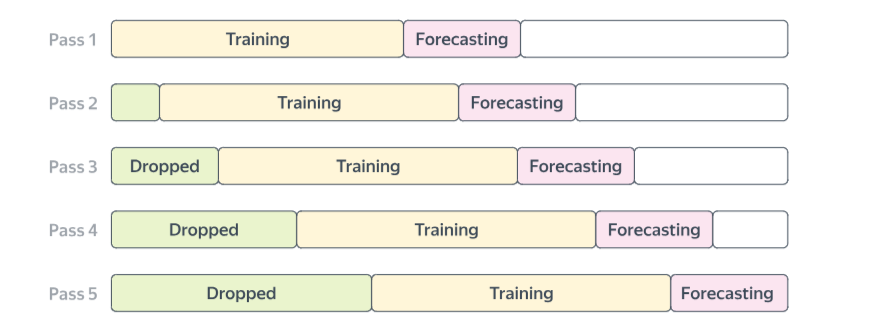

Замечание: в обоих схемах **размер тестового интервала времени фиксирован**. Это необходимое условие, потому как распределение значений метрики на разных размерах данных может отличаться.

# **Декомпозиция временного ряда**

В качестве модели для тренда возьмем полином четвертой степени. Извлечем трендовые значения из исходных данных временного ряда.

In [ ]:
oil_data['remains_trend_4regres'] = oil_data['price'] - oil_data['4regres']
oil_data['remains_trend_nf'] = oil_data['price'] - oil_data['naive_forecast']

In [ ]:
oil_data

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(oil_data['time'], oil_data['price'], label='исходный ряд')
plt.plot(oil_data['time'], oil_data['4regres'], label='тренд')
plt.plot(oil_data['time'], oil_data['remains_trend'], label='остатки от тренда')
plt.plot(oil_data['time'], oil_data['remains_trend_nf'], label='остатки от наивного прогноза')

# Устанавливаем заголовки и легенду
plt.title('График цены на нефть и трендовая компонента')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))
plot_acf(oil_data['price'], ax=ax1, lags=50);

In [ ]:
# анализ ACF остатков после тренда
fig, ax1 = plt.subplots(figsize=(12, 6))
plot_acf(oil_data['remains_trend'], ax=ax1, lags=50);

In [ ]:
# анализ ACF остатков после тренда
fig, ax1 = plt.subplots(figsize=(12, 6))
plot_acf(oil_data['remains_trend_nf'], ax=ax1, lags=50);

In [ ]:
print(f'p-значение критерия Дикки-Фуллера исходного временного ряда: {adfuller(oil_data.price)[1]}')
print(f'p-значение критерия Дикки-Фуллера на остатках от тренда: {adfuller(oil_data.remains_trend)[1]}')
print(f'p-значение критерия Дикки-Фуллера на остатках от наивного прогноза: {adfuller(oil_data.remains_trend_nf)[1]}')

# **PS. Сезонность**

In [ ]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(oil_data['price'],
                                          model='additive',
                                          period=365,
                                          extrapolate_trend='freq')

# Визуализация компонентов временного ряда
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

# Исходный ряд
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Цена')
ax1.set_title('Исходный ряд')

# Тренд
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Цена')
ax2.set_title('Тренд')

# Сезонность
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Цена')
ax3.set_title('Сезонность')

# Остатки
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Цена')
ax4.set_title('Остаток')

plt.tight_layout()
plt.show()

In [ ]:
plot_acf(decomposition.resid, lags=20);